In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import matthews_corrcoef, confusion_matrix, accuracy_score
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork, MarkovNetwork
from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator, BicScore, BayesianEstimator, PC, MmhcEstimator, ExpectationMaximization
from pgmpy.inference import VariableElimination, BeliefPropagation

def combine_data():
    application = pd.read_csv("./dataset/application_record.csv", index_col= None)
    credit = pd.read_csv("./dataset/credit_record.csv", index_col=None)
    join_df = pd.merge(application, credit, on="ID", how='inner')
    columns_to_replace = ["FLAG_OWN_CAR", "FLAG_OWN_REALTY", "FLAG_WORK_PHONE", "FLAG_MOBIL", "FLAG_PHONE", "FLAG_EMAIL"]
    join_df[columns_to_replace] = join_df[columns_to_replace].replace({'Y': 1, 'N': 0})
    indue_status = ["X", "C", "0", "1"]
    risk = join_df["STATUS"].isin(indue_status)
    risk_value = np.where(risk, 0, 1)
    join_df['RISK'] = risk_value
    print(join_df.columns)

    risk_by_id = join_df.groupby('ID')['RISK'].transform('max') == 1
    join_df.loc[risk_by_id, 'RISK'] = 1
    join_df = join_df.drop_duplicates(subset='ID', keep='first')
    print(join_df.columns)

    unique_income_types = join_df["NAME_INCOME_TYPE"].unique()
    unique_education_types = join_df["NAME_EDUCATION_TYPE"].unique()
    unique_family_status = join_df["NAME_FAMILY_STATUS"].unique()
    unique_housing_types = join_df["NAME_HOUSING_TYPE"].unique()
    unique_status_types = join_df["STATUS"].unique()

    print("unique income types: ", unique_income_types)
    print("unique education types: ", unique_education_types)
    print("unique family status: ", unique_family_status)
    print("unique housing types: ", unique_housing_types)
    print("unique status types: ", unique_status_types)

    join_df.to_csv("./dataset/complete_credit_record.csv", index=None)


def data_preprocess():
    credit_data = pd.read_csv("./dataset/complete_credit_record.csv")
    # total_rows = len(credit_data)
    # risk_count = (credit_data["RISK"] == 1).sum()
    # diff = risk_count - (total_rows - risk_count)
    # if diff > 0:
    #     risk_0_rows = credit_data[credit_data['RISK'] == 0]
    #     duplicated_rows = risk_0_rows.sample(n=diff, replace=True)
    #     credit_data = pd.concat([credit_data, duplicated_rows], ignore_index=True)
    # if diff < 0:
    #     risk_0_rows = credit_data[credit_data['RISK'] == 1]
    #     duplicated_rows = risk_0_rows.sample(n=-diff, replace=True)
    #     credit_data = pd.concat([credit_data, duplicated_rows], ignore_index=True)

    columns_to_normalize = ["AMT_INCOME_TOTAL", "DAYS_EMPLOYED", "DAYS_BIRTH"]
    # scaler = StandardScaler()
    # credit_data[columns_to_normalize] = scaler.fit_transform(credit_data[columns_to_normalize])
    for col in columns_to_normalize:
        credit_data[col] = pd.qcut(credit_data[col], q=10, labels=False, duplicates='drop') 

    income_type_dict = {"Working": 5, "Commercial associate": 3, "Pensioner": 3, "State servant": 5, "Student": 1}
    education_type_dict = {"Higher education": 4, "Secondary / secondary special": 2, "Incomplete higher": 3, "Lower secondary": 1, "Academic degree": 5}
    family_type_dict = {"Civil marriage": 3, "Married": 3, "Single / not married": 1, "Separated": 2, "Widow": 2}
    housing_type_dict = {"House / apartment": 5, "Municipal apartment": 4, "Co-op apartment": 3, "Office apartment": 2, "Rented apartment": 1, "With parents": 0}
    gender_type_dict = {"M" : 0, "F": 1}
    
    credit_data["NAME_INCOME_TYPE"] = credit_data["NAME_INCOME_TYPE"].replace(income_type_dict)
    credit_data["NAME_EDUCATION_TYPE"] = credit_data["NAME_EDUCATION_TYPE"].replace(education_type_dict)
    credit_data["NAME_FAMILY_STATUS"] = credit_data["NAME_FAMILY_STATUS"].replace(family_type_dict)
    credit_data["NAME_HOUSING_TYPE"] = credit_data["NAME_HOUSING_TYPE"].replace(housing_type_dict)
    credit_data["CODE_GENDER"] = credit_data["CODE_GENDER"].replace(gender_type_dict)
    credit_data.to_csv("./dataset/oversampling_records.csv", index=None)


def analyze_data():
    credit_data = pd.read_csv("./dataset/oversampling_records.csv")
    binary_features = ["FLAG_OWN_CAR", "FLAG_OWN_REALTY", "FLAG_WORK_PHONE", "FLAG_MOBIL", "FLAG_PHONE", "FLAG_EMAIL"]
    for feat in binary_features:
        sim = matthews_corrcoef(credit_data[feat], credit_data["RISK"])
        print(f"{feat} correlation coefficient {sim}")
    numerical_features = ["CNT_CHILDREN", "AMT_INCOME_TOTAL", "CNT_FAM_MEMBERS", "DAYS_EMPLOYED", "DAYS_BIRTH"]
    for feat in numerical_features:
        correlation_coefficient, p_value = pearsonr(credit_data[feat], credit_data["RISK"])
        print(f"{feat} correlation coefficient {correlation_coefficient}, p-value {p_value}")
    categorical_features = ["NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE"]
    for feat in categorical_features:
        correlation_coefficient, p_value = pearsonr(credit_data[feat], credit_data["RISK"])
        print(f"{feat} correlation coefficient {correlation_coefficient}, p-value {p_value}")
        
        
def oversample(train_data):
    total_rows = len(train_data)
    risk_count = (train_data["RISK"] == 1).sum()
    diff = risk_count - (total_rows - risk_count)
    if diff > 0:
        risk_0_rows = train_data[train_data['RISK'] == 0]
        duplicated_rows = risk_0_rows.sample(n=diff, replace=True)
        train_data = pd.concat([train_data, duplicated_rows], ignore_index=True)
    if diff < 0:
        risk_0_rows = train_data[train_data['RISK'] == 1]
        duplicated_rows = risk_0_rows.sample(n=-diff, replace=True)
        train_data = pd.concat([train_data, duplicated_rows], ignore_index=True)
    return train_data, train_data["RISK"]

/home/jiqing/miniconda3/envs/cs5340/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
combine_data()
data_preprocess()
analyze_data()

/tmp/ipykernel_16752/3491376220.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  join_df[columns_to_replace] = join_df[columns_to_replace].replace({'Y': 1, 'N': 0})


Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE',
       'STATUS', 'RISK'],
      dtype='object')
Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE',
       'STATUS', 'RISK'],
      dtype='object')
unique income types:  ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']
unique education types:  ['Higher education' 'Secondary / secondary special' 'Incomplet

/tmp/ipykernel_16752/3491376220.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  credit_data["NAME_INCOME_TYPE"] = credit_data["NAME_INCOME_TYPE"].replace(income_type_dict)
/tmp/ipykernel_16752/3491376220.py:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  credit_data["NAME_EDUCATION_TYPE"] = credit_data["NAME_EDUCATION_TYPE"].replace(education_type_dict)
/tmp/ipykernel_16752/3491376220.py:71: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, ex

In [3]:
data_df = pd.read_csv("./dataset/oversampling_records.csv", index_col=None)
data_df = data_df.drop(columns=["ID", "FLAG_WORK_PHONE", "FLAG_MOBIL", "FLAG_PHONE", "FLAG_EMAIL", "OCCUPATION_TYPE"])
X_train, X_test, y_train, y_test = train_test_split(data_df, data_df["RISK"], test_size=0.1, random_state=42)
X_train, y_train = oversample(X_train)
X_train = X_train.drop(columns=["RISK", "STATUS"])
X_test = X_test.drop(columns=["RISK", "STATUS"], axis = 1)

In [4]:
X_test

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,MONTHS_BALANCE
21900,1,0,1,0,6,5,2,2,5,4,4,1.0,0
24293,0,1,0,0,9,3,4,3,5,3,6,2.0,0
19633,1,0,0,0,7,5,4,3,5,1,1,2.0,-38
2496,1,1,1,0,9,3,4,3,5,7,7,2.0,0
25932,1,1,0,0,7,5,2,3,4,7,6,2.0,-32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22624,0,1,1,0,2,5,2,1,5,9,7,1.0,0
17277,1,0,1,0,5,3,4,3,5,2,8,2.0,-19
23009,0,0,1,2,5,5,2,3,5,8,5,4.0,-27
1631,1,0,1,0,0,3,2,3,5,2,3,2.0,0


In [5]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)
model.fit(X_train)
clusters = model.transform(X_train)

In [8]:
clusters

array([[ 4.49797107, 28.29299531],
       [ 4.23480637, 28.26985316],
       [ 7.45805428, 28.90344328],
       ...,
       [ 6.73323242, 28.8262926 ],
       [ 3.3077102 , 28.16870386],
       [ 3.65966731, 28.21398193]])

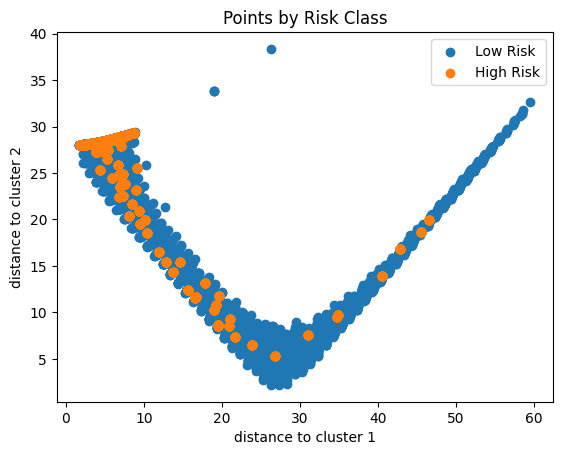

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


for risk in y_train.unique():
    if risk == 0:
        label = "Low Risk"
    else:
        label = "High Risk"
    # Get points corresponding to the current risk
    indices = y_train[y_train == risk].index
    points_to_plot = clusters[indices]
    
    # Plot these points with a label
    plt.scatter(points_to_plot[:, 0], points_to_plot[:, 1], label=label)

# Add legend and labels
plt.legend()
plt.xlabel('distance to cluster 1')
plt.ylabel('distance to cluster 2')
plt.title('Points by Risk Class')
plt.show()

In [14]:
predict = model.fit_predict(X_test, y=None, sample_weight=None)
predict

array([0, 0, 1, ..., 1, 0, 0], dtype=int32)

In [15]:
confusion_matrix(1 - predict, y_test)

array([[ 568,    2],
       [3019,   57]])